# Introduction:  Analysing Tripadvisor Dataset to analyse statistics on hotel locations, user reviews, most seasoned traveller, user experience and more..

Have you ever wondered how travel websites analyse humoungous amount of data and show to us interactive maps? <br>Or Wanted to undersand Where most of popular hotels are located in your favourite city? <br>Or maybe get a timed map showing your footprints on the world? <br>Want to look at the trends in Price range of hotels compared to the popularity of hotel?<br> Understand how personalized user experiences are offered?
<br>
<br>
Lets make an attempt to answer these questions!
<br>
<br>
This tutorial works on a subset of TripAdvisor dataset. TripAdvisor, Inc. is an American travel and restaurant website company providing hotel and restaurant reviews, accommodation bookings and other travel-related content. It also includes interactive travel forums. My motivation behind choosing this dataset was to understand how websites generating a lot of data build their data pipeline. Right from data curation to visualization and even applying machine learning models.

## Tutorial content

In this tutorial,we will be using GeoPy(for curating the dataset), Folium (provides visualizion in a Leaflet map for interactive plots), SpaCy & wordcloud.

We will cover the following topics in this tutorial:<br>
[Installing the libraries](#Installing the libraries)<br>
[Dataset Features](#Dataset Features)<br>
[Finding Best Hotels in your favourite City !](#Finding Best Hotels in your favourite City !)<br>
[Visualizing Statistics in Las Vegas Hotels](#Visualizing Statistics in Las Vegas Hotels)<br>
[Care about a certain feature and want to prioritize?](#Care about a certain feature and want to prioritize?)<br>
[Where are most of the Hotels located? Use HeatMap!](#Where are most of the Hotels located? Use HeatMap!)<br>
[Charting the places travelled by Most Seasoned Traveller](#Charting the places travelled by Most Seasoned Traveller)<br>
[Seasoned traveller's world footprint, visualized!](#Seasoned travellers world footprint visualized)<br>
[How to personalize user experience by mining reviews!](#How to personalize user experience by mining reviews)<br>
[Visualizing Popular Hotels with an Interactive Popup](#Visualizing Popular Hotels with an Interactive Popup)<br>
[Future Scope, Summary and references](#Future Scope, Summary and references)<br>

<a id='Installing the libraries'></a>

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.
<br>
Geopy: <br>pip install --upgrade geopandas geopy<br> 
I use Geopy to further enhance the data set with location tags.
<br>
<br>
Folium: <br>conda install folium -c conda-forge<br> 
Folium is an interactive library for plotting spatial data and has a lot of feature maps that one can choose from.
It is easy to use and plotting on folium is just like plotting with native libraries.
<br>
<br>
Spacy: <br>pip install -U spacy, conda install -c conda-forge spacy<br>
spaCy is a free open-source library featuring state-of-the-art speed and accuracy and a powerful Python API.
<br>
<br>
wordcloud: <br>pip install wordcloud, $conda install -c conda-forge wordcloud



In [132]:
#For general processing
import os, json
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import collections

#For location tagging
from geopy.geocoders import Nominatim
geolocator = Nominatim()

#For language processing
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

#For Visualization
import matplotlib.pyplot as plt
import folium
import folium.plugins as plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

<a id='Dataset Features'></a>
## Dataset Features

Every JSON file within this dataset is a web-scrapped data for a particular hotel, and the JSON structure contains two sub fields:'Reviews' & 'HotelInfo'.There is a lot of content to parsed from this dataset, Within each "Reviews", The "Ratings" contain different fields Service, Cleanliness, Overall, Value, Sleep Quality, Rooms, Location. Other fields are AuthorLocation, Title, Author, ReviewID, Content, Date Finally the "HotelInfo" contains the information about the hotel and has fields as Name, HotelURL, Price, Address (street-address, locality, region, postal-code), HotelID, ImgURL. My reason for choosing this dataset was that I wanted to experiment with visualization and finding hidden correlations amongst the data. The dataset is huge and consists of reviews of about 12773 Hotels. Since I wanted to build the dataset and also experiment with cleaning and curation of data, I used the raw json files given.


This dataset is not perfect and required certain amount of curation before proceeding, some features that are addded, including correcting street-address by using the geopy library to query by extracting features that are available. Also I have used the same library call to fill in latitude and longitude values as well. Another part of my analysis included using a single score for classifying a review as either positive or negative. The dataset in one of the analysis also utilizes a popularity index by taking both reviews count and the overall rating into account.

In [33]:
# The path variable must be initialized to the location where the json files are saved
path = 'data_tripadvisor/others/'
all_files = [file_json for file_json in os.listdir(path) if file_json.endswith('.json')]
print("Total Number of Files to parse:", len(all_files))

Total Number of Files to parse: 12773


In [ ]:
# Curating the dataset and augmenting
all_data = pd.DataFrame()

for file in all_files:
    json_data = pd.DataFrame()
    file_data = pd.DataFrame()
    data_file = path+file
    json_data = pd.read_json(data_file, typ = "Series")
    file_reviews = json_data['Reviews']
    file_info = json_data['HotelInfo']
    print(data_file)
    for review in file_reviews:
        try:
            temp_review = pd.Series(review['Ratings'], name=review['ReviewID'])
            temp_review['Date'] = review['Date']
            temp_review['Author'] = review['Author']
            temp_review['Title'] = review['Title']
            temp_review['Content'] = review['Content']
            temp_review['AuthorLocation'] = review['AuthorLocation'].split(', ')[-1]
            file_data = file_data.append(temp_review)
        except:
            pass
#     print(file_data.head())
    try:
        file_data['HotelID'] = int(file_info['HotelID'])
        file_data['Hotel'] = file_info['Name']
        price_range = [int(''.join([el for el in price if el.isdigit()])) for price in file_info['Price'].split('-')]
        file_data['PriceMin'] = price_range[0]
        file_data['PriceMax'] = price_range[-1]
        address = BeautifulSoup(file_info['Address'], 'lxml')
        street_address = address.find('span', property='v:street-address').text
        locality = address.find('span', property='v:locality').text
        file_data['locality'] = locality
        region = address.find('span', property='v:region').text
        file_data['region'] = region
        country_name = address.find('span', property='v:country-name"').text
        file_data['country_name'] = country_name
    except:
        pass
    all_data=all_data.append(file_data)
    
all_data['Overall']=all_data['Overall'].astype('float')
all_data['Location']=all_data['Location'].astype('float')
all_data['Cleanliness']=all_data['Cleanliness'].astype('float')
all_data['Rooms']=all_data['Rooms'].astype('float')
all_data['Service']=all_data['Service'].astype('float')
all_data['Sleep Quality']=all_data['Sleep Quality'].astype('float')
all_data['Value']=all_data['Value'].astype('float')
all_data['binary_review'] = [1.0 if rating>3.0 else 0.0 for rating in all_data['Overall']]
all_data = all_data.dropna(axis=0, how='all', thresh=None, subset=None)
all_data = all_data.dropna(axis=1, how='all', thresh=None, subset=None)
all_data = all_data.fillna(0.0)
analysed_tripadvisor_data = all_data.drop_duplicates(['Hotel','Author','Content'], keep='first')
analysed_tripadvisor_data.to_pickle('final_analysed_tripadvisor_data.pkl')
# print(analysed_tripadvisor_data.head())

In [3]:
# analysed_tripadvisor_data = pd.read_pickle('analysed_tripadvisor_data.pkl')

In [38]:
# datatypes and example
print(analysed_tripadvisor_data.dtypes)
print(analysed_tripadvisor_data.head(5))

Author                                       object
AuthorLocation                               object
Business service (e.g., internet access)     object
Check in / front desk                        object
Cleanliness                                 float64
Content                                      object
Date                                         object
Hotel                                        object
HotelID                                       int64
Location                                    float64
Overall                                     float64
PriceMax                                    float64
PriceMin                                    float64
Rooms                                       float64
Service                                     float64
Sleep Quality                               float64
Title                                        object
Value                                       float64
locality                                     object
postal-code 

<a id='Finding Best Hotels in your favourite City !'></a>
## Finding Best Hotels in your favourite City !

I got the idea of plotting maps of cities when it comes to data that talks about cities or geo locations. I figured that an interactive library to use is folium, and I wanted to understand how close to green pastures are most hotels located (we only talk about hotels covered in this dataset though). 

For doing this, I chose the city of Las Vegas (most talked about city on Kaggle) and used the Geopy library to populate the latitude and longitude values from the hotel names given. Another metric that I wanted to experiment with was to answer questions like "which is the most popular hotel within a given area". Since the dataset only contains ratings and review counts as two values, it was most logical to combine these two into popularity index for a given hotel.

In [39]:
#Finding hotels in Las Vegas and computing mean statistics
hotel_las_vegas = analysed_tripadvisor_data.loc[(analysed_tripadvisor_data['locality'] == "Las Vegas")]
print("Total Number of Hotel Reviews in Las Vegas:",len(hotel_las_vegas))
groupby_las_vegas = hotel_las_vegas.groupby(['HotelID', 'Hotel'], as_index=False, sort=True)
print("Total Number of Unique Hotels in Las Vegas:",len(groupby_las_vegas))

las_vegas_df = pd.DataFrame()

for name, group in groupby_las_vegas:
    temp_data = pd.DataFrame()
    temp_data['HotelID'] =  group['HotelID'].unique()
    temp_data['Hotel'] = nameH = group['Hotel'].unique()
    street_address = group['street-address'].unique()
    temp_data['rating'] = group['Overall'].mean()
    temp_data['PriceMin'] = group['PriceMin'].mean()
    temp_data['PriceMax'] = group['PriceMax'].mean()
    temp_data['Cleanliness'] = group['Cleanliness'].mean()
    temp_data['Location'] = group['Location'].mean()
    temp_data['Rooms'] = group['Rooms'].mean()
    temp_data['Service'] = group['Service'].mean()
    temp_data['Sleep Quality'] = group['Sleep Quality'].mean()
    temp_data['Value'] = group['Value'].mean()
    temp_data['region'] = group['region'].unique()
    temp_data['review_count'] = len(group['Overall'])
    location = geolocator.geocode(nameH, timeout=10)
    if (location):
            try:
                temp_data['address'] = location.address
                temp_data['latitude'] = location.latitude
                temp_data['longitude'] = location.longitude
            except:
                continue
    else:
            location = geolocator.geocode(street_address, timeout=10)
            if (location):
                try:
                    temp_data['address'] = location.address
                    temp_data['latitude'] = location.latitude
                    temp_data['longitude'] = location.longitude
                except:
                    continue
            else:
                temp_data['address'] = street_address
    las_vegas_df = las_vegas_df.append(temp_data)
    
las_vegas_df['popularity'] = [(row['rating']*row['review_count']) for index, row in las_vegas_df.iterrows() ]
print(las_vegas_df.head())

Total Number of Hotel Reviews in Las Vegas: 95050
Total Number of Unique Hotels in Las Vegas: 236
   HotelID                               Hotel  rating  PriceMin  PriceMax  \
0    76082           BEST WESTERN McCarran Inn     5.0      61.0     111.0   
0    91673        Rio All-Suite Hotel & Casino     4.0      61.0     231.0   
0    91674        Four Seasons Hotel Las Vegas     4.0     213.0     419.0   
0    91675  Sam's Town Hotel and Gambling Hall     5.0      39.0     102.0   
0    91679          Fitzgeralds Casino & Hotel     3.0      30.0      86.0   

   Cleanliness  Location  Rooms  Service  Sleep Quality  Value region  \
0          5.0      4.00   5.00      5.0            5.0   5.00     NV   
0          4.0      3.25   4.25      3.5            3.0   4.25     NV   
0          4.0      4.00   3.50      5.0            2.0   4.00     NV   
0          5.0      5.00   5.00      5.0            5.0   5.00     NV   
0          3.0      3.00   3.00      4.0            4.0   4.00     N

<a id='Visualizing Statistics in Las Vegas Hotels'></a>
## Visualizing Statistics in Las Vegas Hotels

Lets start by looking at certain key statistics within the dataset. How about looking at a correlation between the PriceMin & PriceMax values according to popularight? Clearly hotels with a wide range in Price Range and still popular could be a better choice? With a lot of metrics involved it would also be insightful to understand how these values vary with popularity?

In [68]:
most_popular_las_vegas = las_vegas_df.sort_values(by='popularity', ascending = False)

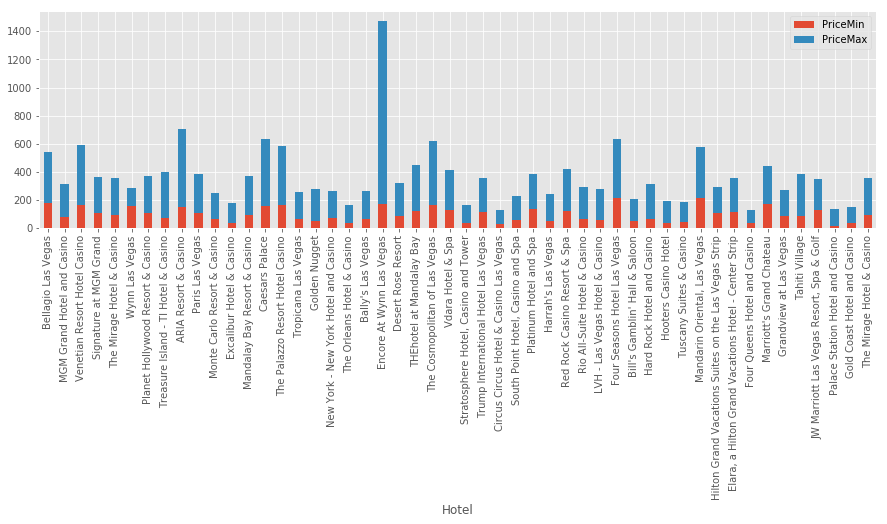

In [69]:
# Check for correlation between Price Range and popularity index for top hotels
plt.figure()
most_popular_popularity = most_popular_las_vegas[0:50]
most_popular_popularity = most_popular_popularity[['Hotel','PriceMin','PriceMax']]
plot = most_popular_popularity.plot(x='Hotel', kind='bar', stacked=True, figsize=(15, 4))

<a id='Care about a certain feature and want to prioritize?'></a>
## Care about a certain feature and want to prioritize?

In this attempt, lets try and visualize how metrics like Cleanliness, Location, Rooms, Service, Sleep Quality, Value (price) vary around the top 15 and the least 15.

Interesting Insight: By plotting hotels from top and bottom using the popularity index that was calculated by combining both ratings and review count, we can clearly see that even the bottom most hotels by ranking can have one feature or the other offered better than top few. Just looking at popularity index is therefor not enough, recommendation engines on sophisticated architectures probably take tons of metrics into account and also normalize values accordingly. 

Text(0.5,1,'Most Not Popular bottom 15')

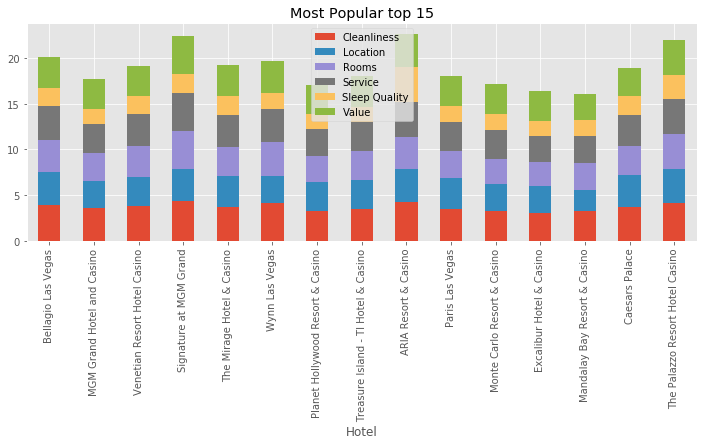

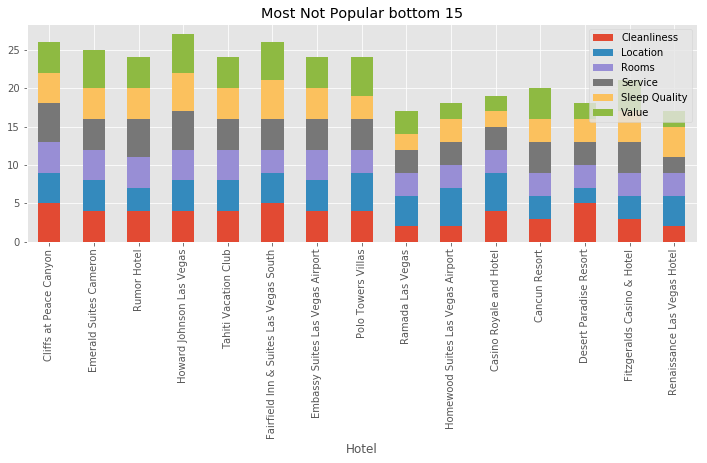

In [70]:
# Check for correlation between metrics and popularity index for top & bottom hotels
plt.figure()
most_popular_metrics = most_popular_las_vegas.iloc[0:15]
most_not_popular_metrics = most_popular_las_vegas.iloc[-15:]
most_popular_metrics = most_popular_metrics[['Hotel', 'Cleanliness','Location','Rooms','Service','Sleep Quality','Value']]
most_not_popular_metrics = most_not_popular_metrics[['Hotel', 'Cleanliness','Location','Rooms','Service','Sleep Quality','Value']]
popular_metrics_plot = most_popular_metrics.plot(x='Hotel', kind='bar', stacked=True, figsize=(12, 4))
popular_metrics_plot.set_title('Most Popular top 15')
not_popular_metrics_plot = most_not_popular_metrics.plot(x='Hotel', kind='bar', stacked=True, figsize=(12, 4))
not_popular_metrics_plot.set_title('Most Not Popular bottom 15')

<a id='Where are most of the Hotels located? Use HeatMap!'></a>
## Where are most of the Hotels located? Use HeatMap!

After we have the values from hotel in las_vegas, we can use the HeatMap feature from folium library to plot the data.
This map is initialized at Las Vegas, and we can observe that most hotels are located closer to the airport near the city
and densely populated in the northern part of the region.

In [99]:
#To find density of hotels within the city
rating_vegas=las_vegas_df[['Hotel','latitude','longitude','rating','review_count']]
map_las_vegas = folium.Map(location=[36.127430, -115.138460], tiles = "Stamen Terrain", zoom_start = 12)
heat_data = [[row['latitude'],row['longitude']] for index, row in rating_vegas.iterrows()]
HeatMap(heat_data).add_to(map_las_vegas)
map_las_vegas.save('map_las_vegas.html')
# Use the command below to run it in Notebook
# map_las_vegas

### Please run the cell below to see the interactive map
If the cells do not render please check the image after next cell

In [119]:
%%HTML
<iframe width="100%" height="600" src="map_las_vegas.html"></iframe>

![map_las_vegas.png](map_las_vegas.png)

<a id='Charting the places travelled by Most Seasoned Traveller'></a>
## Charting the places travelled by Most Seasoned Traveller

An interesting idea would be to find the most seasoned traveller in this dataset. This would require finding out the Author with the maximum number of reviews, the results below show that certain Author names are not specified and are arbitrary. On reading more I figured out that 'A TripAdvisor Member', 'Posted by an Accorhotels.com traveler', 'Posted by an Easytobook.com traveler, Posted by a hotelsgrandparis.com traveler' are reviews that were curated by Tripadvisor and flagged. We therefore look at the next Author by name and it appears to be 'David S'.

This could be an interesting feature that travel websites could show to an individual user and provide insights on the locations the user has travelled or how much of the world is covered.

In [73]:
# Computing counts of author reviews
data_author = analysed_tripadvisor_data
print("Total number of reviews: ",len(data_author))
total_author_df = data_author['Author'].tolist()
counter=collections.Counter(total_author_df)
print(counter.most_common(20))

Total number of reviews:  1033900
[('A TripAdvisor Member', 35399), ('Posted by an Accorhotels.com traveler', 4351), ('Posted by an Easytobook.com traveler', 234), ('Posted by a hotelsgrandparis.com traveler', 89), ('David S', 66), ('John S', 64), ('Pawel_EPWR', 61), ('John C', 61), ('David M', 60), ('ITA_And_RE_a', 60), ('David B', 57), ('John M', 55), ('John B', 52), ('Posted by a La Quinta traveler', 50), ('David C', 48), ('Paul B', 47), ('David H', 47), ('Chris B', 46), ('John H', 44), ('John W', 43)]


In [74]:
# Building dataframe for most reviews by user
most_review_user = data_author[data_author['Author']=='David S']
most_review_user = most_review_user[['Author','AuthorLocation','Content','Date','Hotel','Overall','street-address','region','locality']]
most_review_user = most_review_user.dropna(axis=0, how='any', thresh=None, subset=['street-address','region','locality'])
print("Number of Reviews by the User with most reviews in the Dataset:", len(most_review_user))

for index, row in most_review_user.iterrows():
    try:
        location = geolocator.geocode(row['Hotel'])
        if (location):
            most_review_user.loc[index,'address'] = location.address
            most_review_user.loc[index,'latitude'] = location.latitude
            most_review_user.loc[index,'longitude'] = location.longitude
        
        else:
            location = geolocator.geocode(row['locality'])
            most_review_user.loc[index,'address'] = location.address
            most_review_user.loc[index,'latitude'] = location.latitude
            most_review_user.loc[index,'longitude'] = location.longitude
    except:
        pass

    
# print(most_review_user.head(3))

Number of Reviews by the User with most reviews in the Dataset: 66


<a id='Seasoned travellers world footprint visualized'></a>
## Seasoned traveller's world footprint, visualized!

We have now created a dataframe that has both Date of visit to a hotel and its location coordinates, How about creating a folium map that can display this in order? 

In [112]:
# Visualizing locations travelled by most seasoned traveller with time
most_review_user = most_review_user.dropna(axis=0, how='any', thresh=None, subset=['latitude','longitude'])
most_review_user['Date'] = pd.to_datetime(most_review_user['Date'])
most_review_user = most_review_user.sort_values(by='Date')
data_to_plot=[]

date=list(most_review_user['Date'])

for val in date:
    subset=most_review_user[most_review_user['Date']==val]
    data_to_plot.append(subset[['latitude','longitude']].values.tolist())

travel_map_author = folium.Map(location=[20,0], tiles="Mapbox Bright", zoom_start=2) 
heatmap = plugins.HeatMapWithTime(data_to_plot,auto_play=True,display_index=True, radius=20)
heatmap.add_to(travel_map_author)
travel_map_author.save('travel_map_author.html')
print(" Use Play Button in the Iframe for visualization in Iframe window")

 Use Play Button in the Iframe for visualization 


### Please run the cell below to see the interactive map
If the cells do not render please check the image after next cell

In [115]:
%%HTML
<iframe width="100%" height="600" src="travel_map_author.html"></iframe>

![travel_map_author](travel_map_author.png)

<a id='How to personalize user experience by mining reviews'></a>
## How to personalize user experience by mining reviews?

Every review by a user gives a lot of insight and if efficiently analysed can provide insights more than ratings. My idea behind analysing the reviews was to figure out in some simplistic way about things that the user talks more about in his/her reviews. There can definitely be more sense made out of this. This analysis requires processing the text and removing stop words as well. For an easy visualization, I use the WordCloud library, which does the text processing as well. All reviews from our most seasoned traveller are combined and then fed to generate a wordcloud. The next time a user visits the website a prediction algorithm can factor such metrics already and provide a personalised experience, maybe using a chat-bot!

Key Insights : From the word cloud it is apparent that the user talks a lot about staff, clean, location, service, amenities, property, street, professional etc.
This analysis is not complete in itself, since one must remove stop words like hotel or stay which need exhaustive analysis.

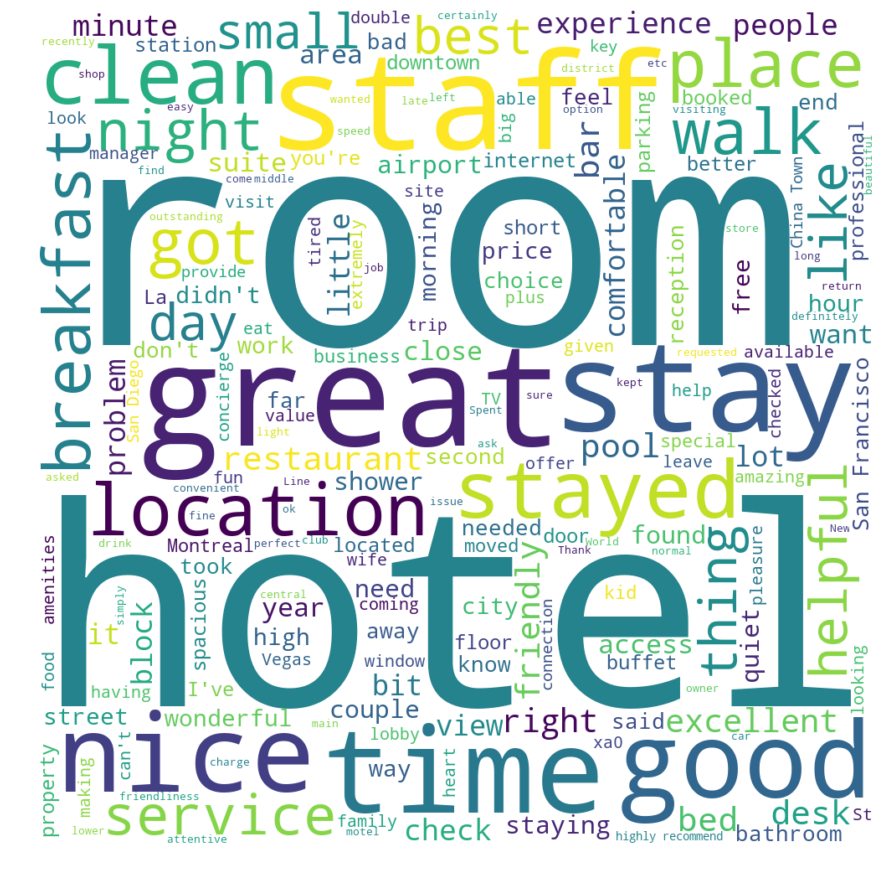

In [131]:
# Building wordcloud with all reviews from a user
text = most_review_user['Content'].tolist()
text = str(text)
wordcloud = WordCloud(width=1000, height=1000, background_color="white", stopwords=STOP_WORDS).generate_from_text(text)
plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

<a id='Visualizing Popular Hotels with an Interactive Popup'></a>
## Visualizing Popular Hotels with an Interactive Popup
It would be interesting to show a user of a travel website the most popular hotels within an area and an interactive map that could display more data about that hotel (like ratings, address , price range etc.) In the following cell I make use of the popup feature from folium maps that displays an interactive map for this.

In [103]:
# Plotting key statistics with an Interactive Popup on the Map!
review_vegas_df = las_vegas_df.dropna(axis=0, how='any', thresh=None, subset=None)
review_vegas_df = review_vegas_df.sort_values(by='popularity', ascending = False)
map_las_vegas_popular = folium.Map(location=[36.106970, -115.166526], tiles="openstreetmap", zoom_start=14)
data = pd.DataFrame()
data = review_vegas_df[['latitude','longitude']].copy()
data['details'] = [row['Hotel']+" \nRating:"+str("{0:.2f}".format(row['rating'])) for index, row in review_vegas_df.iterrows()]

for i in range(0,11):
    folium.Marker([data.iloc[i]['latitude'], data.iloc[i]['longitude']], popup=data.iloc[i]['details']).add_to(map_las_vegas_popular)

map_las_vegas_popular.save('map_las_vegas_popular.html')

### Please run the cell below to see the interactive map
If the cells do not render please check the image after next cell

In [104]:
%%HTML
<iframe width="100%" height="600" src="map_las_vegas_popular.html"></iframe>

![map_las_vegas_popular](map_las_vegas_popular.png)

<a id='Future Scope, Summary and references'></a>
## Future Scope, Summary and references

Further to this attempt, It is also possible to train a model using the reviews with binary-review classification. All such reviews can also be applied to NLP libraries to train a model to figure out what a review liked the most in a given hotel.

GeoPy: https://geopy.readthedocs.io<br>
Dataset : http://times.cs.uiuc.edu/~wang296/Data/ (Please download the dataset linked by heading JSON)<br>
Folium : https://github.com/python-visualization/folium<br>
Spacy: https://spacy.io/<br>
WordCloud: https://amueller.github.io/word_cloud/